In [2]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

In [3]:
# load in the data
df = pd.read_csv("C://Users//Admin//Documents//GitHub//small_rating.csv")
titledf=pd.read_csv("C://Users//Admin//Downloads//archive//movie.csv")

N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
# reg = 0.0001 # regularization penalty


# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)

# the neural network
x = Dense(400)(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(100)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  )
)

C:\Users\Admin\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
33701/33701 [==============================] - 121s 4ms/step - loss: 0.6717 - mse: 0.6717 - val_loss: 0.6375 - val_mse: 0.6375
Epoch 2/15
33701/33701 [==============================] - 104s 3ms/step - loss: 0.6316 - mse: 0.6316 - val_loss: 0.6330 - val_mse: 0.6330
Epoch 3/15
33701/33701 [==============================] - 103s 3ms/step - loss: 0.6162 - mse: 0.6162 - val_loss: 0.6109 - val_mse: 0.6109
Epoch 4/15
33701/33701 [==============================] - 128s 4ms/step - loss: 0.6045 - mse: 0.6045 - val_loss: 0.6076 - val_mse: 0.6076
Epoch 5/15
33701/33701 [==============================] - 135s 4ms/step - loss: 0.5929 - mse: 0.5929 - val_loss: 0.5950 - val_mse: 0.5950
Epoch 6/15
33701/33701 [==============================] - 135s 4ms/step - loss: 0.5838 - mse: 0.5838 - val_loss: 0.6010 - val_mse: 0.6010
Epoch 7/15
33701/33701 [==============================] - 135s 4ms/step - loss: 0.5746 - mse: 0.5746 - val_loss: 0.5774 - val_mse: 0.5774
Epoch 8/15
33701/33701 [==========

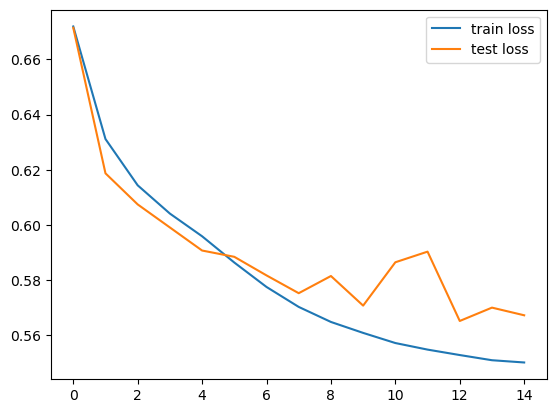

KeyError: 'mean_squared_error'

In [4]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()

In [4]:
# Get all movie IDs
movie_ids = df['movie_idx'].unique()

# Get all movies that user 100 has not yet rated
movies_100_not_rated = df[~df['userId'].isin([100])]['movie_idx'].unique()

# Create a list of tuples containing the user ID (100) and all movie IDs
user_100_movie_tuples = [(100, movie_id) for movie_id in movie_ids]

# Use the trained model to predict the ratings for all movies for user 100
predicted_ratings = model.predict([np.array([t[0] for t in user_100_movie_tuples]), np.array([t[1] for t in user_100_movie_tuples])])

# Create a dictionary containing the predicted ratings for each movie
movie_ratings_dict = {movie_id: predicted_ratings[i][0] for i, movie_id in enumerate(movie_ids)}

# Sort the movie IDs by their predicted rating for user 100
sorted_movie_ids = sorted(movie_ratings_dict, key=movie_ratings_dict.get, reverse=True)

# Get the top 10 movies that user 100 has not yet rated
top_10_movies = [movie_id for movie_id in sorted_movie_ids if movie_id in movies_100_not_rated][:10]

# Print the recommended movies
print("Recommended movies for user 100:")
for movie_id in top_10_movies:
    movie_title = titledf[df['movie_idx'] == movie_id]['title'].values[0]
    print("- ", movie_title)


63/63 [==============================] - 0s 2ms/step
Recommended movies for user 100:


C:\Users\Admin\AppData\Local\Temp\ipykernel_4172\2400732005.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movie_title = titledf[df['movie_idx'] == movie_id]['title'].values[0]


-  Clueless (1995)
-  Othello (Tragedy of Othello: The Moor of Venice, The) (1952)
-  Bringing Up Baby (1938)
-  Designated Mourner, The (1997)
-  King of California (2007)
-  Simple Wish, A (1997)
-  Cruel Story of Youth (Seishun zankoku monogatari) (1960)
-  Afterglow (1997)
-  Bio-Dome (1996)
-  Second Jungle Book: Mowgli & Baloo, The (1997)
